# Library

In [1]:
import utils
import pandas as pd
import model
import numpy as np
import requests
import io
import plotly.express as px
import matplotlib.pyplot as plt
import optuna
from keras.callbacks import History 


# Data

In [2]:
df = pd.read_csv('../gams_indoor.csv')

In [3]:
df_t = utils.preprocessing(df, 'pm10', '5min', 0, 1)

In [4]:
df_t.head()

ts
2016-11-21 00:45:00    10.433333
2016-11-21 00:50:00     8.160000
2016-11-21 00:55:00     7.720000
2016-11-21 01:00:00     6.560000
2016-11-21 01:05:00     5.940000
Name: pm10, dtype: float64

# Preprocessing

In [5]:
split = utils.train_test_split(df_t)
training_set = split[0]
testing_set = split[1]

# Model optimization

In [6]:
def objective(trial):
    lookback = trial.suggest_int('lookback', 3, 24)
    training_data = utils.training_data(window=3, lookback=lookback, train=training_set)
    
    forecaster = model.TS_predictor(lstm_cell = trial.suggest_int('lstm_cell', 50, 100),
                                          window = 3,
                                          lookback = lookback,
                                          optimizer = 'adam',
                                          loss = 'mean_absolute_percentage_error'
                                         )

    h = forecaster.train(epochs = 10,
                     batch_size = 32,
                     training_data = training_data
                    )
    
    return h.history['val_loss'][-1]

In [7]:
study = optuna.create_study(study_name='lstm_opt', direction='minimize')
study.optimize(objective, n_trials=10)

[I 2022-10-31 16:43:28,369] A new study created in memory with name: lstm_opt


Epoch 1/10
529/536 [============================>.] - ETA: 0s - loss: 28.7728

[W 2022-10-31 16:43:37,628] Trial 0 failed because of the following error: KeyboardInterrupt()
Traceback (most recent call last):
  File "C:\Users\Hugo\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\Hugo\AppData\Local\Temp\ipykernel_17664\3350331569.py", line 12, in objective
    h = forecaster.train(epochs = 10,
  File "C:\Users\Hugo\unsw\UNSW_TS_forecast\model.py", line 31, in train
    return self.lstm_model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_split=0.3, callbacks=[tensorboard_callback])
  File "C:\Users\Hugo\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "C:\Users\Hugo\anaconda3\lib\site-packages\keras\engine\training.py", line 1606, in fit
    val_logs = self.evaluate(
  File "C:\Users\Hugo\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
    return 

KeyboardInterrupt: 

In [25]:
study.best_trial.params

{'lookback': 24, 'lstm_cell': 90}

In [26]:
training_data = utils.training_data(window=3, lookback=study.best_trial.params['lookback'], train=training_set)
testing_data = utils.testing_data(window=3, lookback=study.best_trial.params['lookback'], test=testing_set)

forecaster = model.TS_predictor(lstm_cell = study.best_trial.params['lstm_cell'],
                                  window = 3,
                                  lookback = study.best_trial.params['lookback'],
                                  optimizer = 'adam',
                                  loss = 'mean_absolute_percentage_error'
                                 )

forecaster.train(epochs = 10,
                 batch_size = 32,
                 training_data = training_data
                )

Epoch 1/10
535/535 [==============================] - 11s 17ms/step - loss: 25.2314 - val_loss: 11.8892
Epoch 2/10
535/535 [==============================] - 9s 17ms/step - loss: 11.6529 - val_loss: 8.8310
Epoch 3/10
535/535 [==============================] - 11s 21ms/step - loss: 9.7148 - val_loss: 7.8469
Epoch 4/10
535/535 [==============================] - 11s 21ms/step - loss: 8.8773 - val_loss: 7.4369
Epoch 5/10
535/535 [==============================] - 11s 21ms/step - loss: 8.4703 - val_loss: 7.3609
Epoch 6/10
535/535 [==============================] - 11s 20ms/step - loss: 8.0938 - val_loss: 6.8866
Epoch 7/10
535/535 [==============================] - 11s 21ms/step - loss: 7.8902 - val_loss: 6.7259
Epoch 8/10
535/535 [==============================] - 11s 21ms/step - loss: 7.7930 - val_loss: 6.6479
Epoch 9/10
535/535 [==============================] - 11s 21ms/step - loss: 7.7120 - val_loss: 7.4531
Epoch 10/10
535/535 [==============================] - 12s 22ms/step - loss: 7.6

# Result

In [27]:
predicitons = forecaster.predict(testing_data)

328/328 [==============================] - 2s 5ms/step


In [30]:
predicitons

array([[22.85827  , 22.436642 , 22.260635 ],
       [24.381208 , 24.099205 , 23.802542 ],
       [22.440723 , 22.041374 , 21.759338 ],
       ...,
       [ 5.1809583,  5.0846844,  5.0498185],
       [ 5.7966886,  5.7222934,  5.685333 ],
       [ 5.9814568,  5.8958087,  5.8652587]], dtype=float32)

In [31]:
testing_data[0][:,-1]

array([[23.48],
       [25.92],
       [22.82],
       ...,
       [ 5.1 ],
       [ 6.16],
       [ 6.12]])

## visualize 1

In [34]:
df = pd.read_csv('../gams_indoor.csv')
df['ts'] = pd.to_datetime(df['ts'])
df = df.resample('5min', on='ts').mean()
df = df.dropna()
df = df.loc[testing_set.index][:-27]
df.to_csv('demo.csv')

In [35]:
df = pd.read_csv('demo.csv', index_col=[0])
df[['pm10+1', 'pm10+2', 'pm10+3']]=predicitons
df.to_csv('demo.csv')

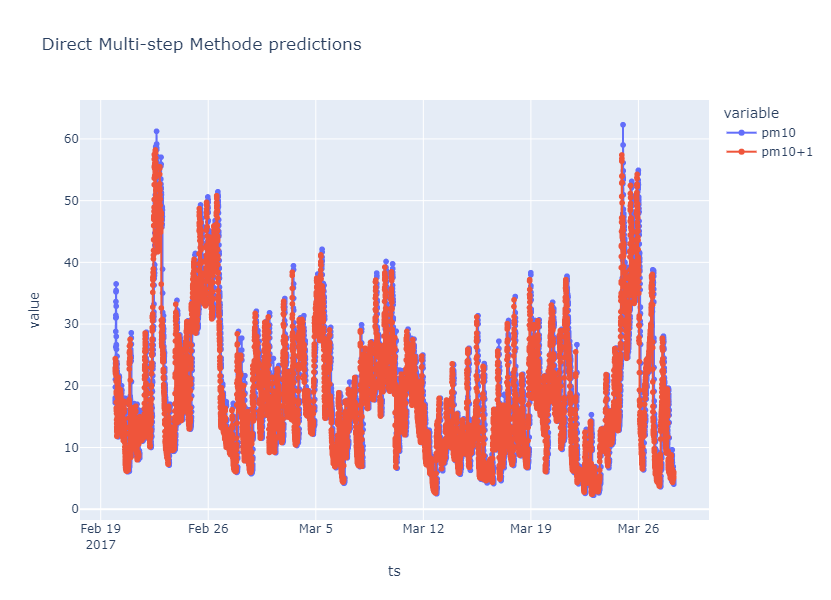

In [36]:
fig = px.line(df[['pm10', 'pm10+1']], title='Direct Multi-step Methode predictions', markers=True, width=1000, height=600)
fig.show()

In [22]:
BASE_URL = "https://0bqlp3t8ng.execute-api.ap-southeast-2.amazonaws.com/v1"

def get_csv_as_dataframe(source_type: str, source_name: str, ts: str, table: str):
    get_url_endpoint = f"{BASE_URL}/{source_type}/{source_name}/{ts}/{table}"
    url = requests.get(get_url_endpoint).json()['url']
    file_content = requests.get(url).content.decode()
    file_string = io.StringIO(file_content)
    return pd.read_csv(file_string)

def put_dataframe(df, source_type: str, source_name: str, ts: str, table: str):
    put_url_endpoint = f"{BASE_URL}/{source_type}/{source_name}/{ts}/{table}"
    url = requests.put(put_url_endpoint).json()['url']
    
    csv = df.to_csv(index=False)
    
    res = requests.put(
        url=url,
        data=csv,
        headers={'Content-Type': 'text/csv'}
    )
    return res.status_code

In [23]:
put_dataframe(df.reset_index(level=0), 'web', 'gams', 'global', 'indoor_5m_3p.csv')

200